In [1]:
versioninfo()

Julia Version 1.12.3
Commit 966d0af0fd (2025-12-15 11:20 UTC)
Build Info:

    Note: This is an unofficial build, please report bugs to the project
    responsible for this build and not to the Julia project unless you can
    reproduce the issue using official builds available at https://julialang.org

Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: 16 × AMD Ryzen 7 7800X3D 8-Core Processor
  WORD_SIZE: 64
  LLVM: libLLVM-18.1.7 (ORCJIT, znver4)
  GC: Built with stock GC
Threads: 16 default, 1 interactive, 16 GC (on 16 virtual cores)
Environment:
  JULIA_NUM_THREADS = 16


In [2]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

Base.active_project()
Threads.nthreads()

using UnfoldSim
using Random: MersenneTwister, shuffle
using Distributions: LogNormal, pdf, Geometric
using Statistics: mean
using StatsModels: @formula
using UnfoldSim: PinkNoise, WhiteNoise, RedNoise, ExponentialNoise, NoNoise

import UnfoldSim.simulate_component
import Base: length

  Activating project at `~/Dokumente/BA2/notebooks/data_generation`
Precompiling packages...
    567.0 ms  ✓ StructUtils → StructUtilsTablesExt
    717.1 ms  ✓ EnzymeCore
    605.3 ms  ✓ WoodburyMatrices
    252.0 ms  ✓ EnzymeCore → AdaptExt
    251.0 ms  ✓ ADTypes → ADTypesEnzymeCoreExt
    282.8 ms  ✓ Optimisers → OptimisersEnzymeCoreExt
    369.5 ms  ✓ AxisAlgorithms
    463.0 ms  ✓ KernelAbstractions → EnzymeExt
    521.9 ms  ✓ NNlib → NNlibEnzymeCoreExt
   1612.0 ms  ✓ Interpolations
    561.3 ms  ✓ Interpolations → InterpolationsUnitfulExt
    813.4 ms  ✓ KernelDensity
   1121.4 ms  ✓ ImageTransformations
   1841.1 ms  ✓ ImageContrastAdjustment
   4640.2 ms  ✓ Flux
   3518.4 ms  ✓ Unfold
   7127.1 ms  ✓ CUDA → EnzymeCoreExt
   2649.7 ms  ✓ Images
   3053.8 ms  ✓ Unfold → UnfoldBSplineKitExt
   7532.3 ms  ✓ Unfold → UnfoldCUDAExt
  59385.7 ms  ✓ Makie
   3363.5 ms  ✓ MakieThemes
  12663.5 ms  ✓ TopoPlots
  21675.7 ms  ✓ CairoMakie
  23184.6 ms  ✓ AlgebraOfGraphics
   2977.4 ms  ✓ 

In [3]:
Threads.nthreads()

16

In [4]:
# Minimal component wrapper for UnfoldSim.
struct TimeVaryingComponent <: AbstractComponent
    basisfunction::Any
    maxlength::Any
    beta::Any
end

# Use maxlength as component length.
Base.length(c::TimeVaryingComponent) = c.maxlength

# Simulate a time-varying component with explicit RNG.
function UnfoldSim.simulate_component(rng, c::TimeVaryingComponent, design::AbstractDesign)
    evts = generate_events(deepcopy(rng), design)

    data = c.beta .* c.basisfunction(evts, c.maxlength)
    return truncate_basisfunction(data, c.maxlength)

end

# Simulate a time-varying component with default RNG.
function UnfoldSim.simulate_component(c::TimeVaryingComponent, design::AbstractDesign; rng = MersenneTwister(time_ns()))
    return UnfoldSim.simulate_component(rng, c, design)
end

"""
    basis_linear(evts, maxlength)

Simulate linear basis. Create abline EPR pattern /.

## Arguments

- `evts::DataFrame`\
    Experimental events for simulated data.
- `maxlength::DataFrame`\
    Maximum length of the basis function.

**Return Value:** basis. 
"""
function basis_linear(evts, maxlength)
    shifts = -round.(Int, evts.duration_linear)
    basis = pad_array.(Ref(UnfoldSim.DSP.hanning(50)), shifts, 0)
    return basis
end

"""
    basis_lognormal(evts, maxlength)

Simulate lognormal basis. Creates ERP pattern called asymetrical fan |/.

## Arguments

- `evts::DataFrame`\
    Experimental events for simulated data.
- `maxlength::DataFrame`\
    Maximum length of the basis function.

**Return Value:** basis. 
"""
function basis_lognormal(evts, maxlength)
    basis =
        pdf.(
            LogNormal.(evts.duration ./ 40 .- 0.2, 1),
            Ref(range(0, 10, length = maxlength)),
        )
    basis = basis ./ maximum.(basis)
    return basis
end

"""
    basis_hanning(evts, maxlength)

Simulate Hanning basis. Creates ERP pattern called symmetrical fan V.

## Arguments

- `evts::DataFrame`\
    Experimental events for simulated data.
- `maxlength::DataFrame`\
    Maximum length of the basis function.

**Return Value:** basis. 
"""
function basis_hanning(evts, maxlength)
    if "durationB" ∈ names(evts)
        fn = "durationB"
    else
        fn = "duration"
    end
    maxdur = maximum(evts[:, fn])

    basis = UnfoldSim.DSP.hanning.(Int.(round.(evts[:, fn])))
    shifts = Int.(.-round.(maxdur .- evts[:, fn]) .÷ 2)
    basis = pad_array.(basis, shifts, 0)
    return basis
end

"""
    truncate_basisfunction(evts, maxlength)

Check that all bases have maxlength by appending or truncating.

## Arguments

- `evts::DataFrame`\
    Experimental events for simulated data.
- `maxlength::DataFrame`\
    Maximum length of the basis function.

**Return Value:** basis. 
"""
function truncate_basisfunction(basis, maxlength)
    difftomax = maxlength .- length.(basis)
    if any(difftomax .< 0)
        @warn "Basis longer than maxlength in at least one case. Either increase maxlength or redefine function. Attempt to truncate the basis"
        basis[difftomax.>0] = pad_array.(basis[difftomax.>0], difftomax[difftomax.>0], 0)
        basis = [b[1:maxlength] for b in basis]
    else
        basis = pad_array.(basis, difftomax, 0)
    end
    return reduce(hcat, basis)
end


truncate_basisfunction

In [5]:
# Override noiselevel when supported by the noise type.
function _with_noiselevel(noise, noiselevel::Int)
    if hasproperty(noise, :noiselevel)
        fields = fieldnames(typeof(noise))
        kwargs = (; (f => getfield(noise, f) for f in fields if f != :noiselevel)..., noiselevel = noiselevel)
        return typeof(noise)(; kwargs...)
    end
    return noise
end

"""
    simulate_6patterns(μ = 3.2, σ = 0.5; maxlength::Int = 100, condition_levels::Int = 8,
        noise = PinkNoise(), noiselevel_dist = Geometric(0.25), rng = MersenneTwister(time_ns()))

Simulate 6 ERP patterns in one dataset.
Simulated patterns: Sigmoid, One-sided fan, Two-sided fan, Diverging bar, Hourglass bar, Tilted bar.
Columns in resulting sim_6patterns Data Frame to simulate this patterns: Δlatency, duration, durationB, iscar, continuous, duration_linear.

## Arguments

- `maxlength::Int = 100`    Length of the time-varying components.
- `condition_levels::Int = 8`    Number of levels for simulated conditions.

- `μ::Float = 3.2`    Controls mean.
- `σ::Float = 0.5`    Controls standart deviation.

## `kwargs...`
- `noise = PinkNoise()`    Noise model passed to `simulate`.
- `noiselevel_dist = Geometric(0.25)`    Distribution used to sample an integer noiselevel (sampled as `1 + rand(rng, noiselevel_dist)`).
- `rng::MersenneTwister = MersenneTwister(time_ns())`    Random number generator.

**Return Value:** `sim_6patterns::Matrix{Float64}` with voltages, `sim_evts::DataFrame` with events, and `noiselevel::Int`.

"""
# Simulate six ERP patterns and return raw time x trials data.
function simulate_6patterns(μ=3.2, σ=0.5; maxlength::Int=100, condition_levels::Int=8, noise = PinkNoise(), noiselevel_dist = Geometric(0.50), rng=MersenneTwister(time_ns()))
    design = SingleSubjectDesign(;
        conditions = Dict(
            :condition => ["car", "face"],
            :continuous => range(-2, 2, length=condition_levels),
            :duration => range(20, 100, length=condition_levels),
            :durationB => range(10, 30, length=condition_levels),
            :duration_linear => range(5, 40, length=condition_levels),
        ),
        event_order_function = (rng, x) -> shuffle(rng, x),
    )

    p1 = LinearModelComponent(; basis = p100(), formula = @formula(0 ~ 1), β = [5])

    n1 = LinearModelComponent(;
        basis = n170(),
        formula = @formula(0 ~ 1 + condition + continuous),
        β = [5, 3, 2],
    )

    p3 = LinearModelComponent(; basis = p300(), formula = @formula(0 ~ 1), β = [5])
    componentA = TimeVaryingComponent(basis_lognormal, maxlength, 5)
    componentB = TimeVaryingComponent(basis_hanning, maxlength, -10)
    componentC = TimeVaryingComponent(basis_linear, maxlength, 5)

    noiselevel = max(1, Int(1 + rand(rng, noiselevel_dist)))
    noise = _with_noiselevel(noise, noiselevel)

    # Check for ExponentialNoise
    use_exp_noise = noise isa ExponentialNoise
    noise_for_sim = use_exp_noise ? NoNoise() : noise

    data, sim_evts = simulate(
        rng,
        design,
        [p1, n1, p3, componentA, componentB, componentC],
        LogNormalOnset(; μ = μ, σ = σ),#UniformOnset(; width = 30, offset = 30),
        noise_for_sim,
        return_epoched = true,
    )
    if use_exp_noise
        for trial in axes(data, 2)
            data[:, trial] .+= UnfoldSim.simulate_noise(rng, noise, size(data, 1))
        end
    end
    sim_evts.Δlatency = vcat(diff(sim_evts.latency), 0) # divide time on epochs
    sim_6patterns = data # raw epoched data (z-score applied downstream)
    return sim_6patterns, sim_evts, noiselevel
end


simulate_6patterns (generic function with 3 methods)

In [6]:
data, evts, noiselevel = simulate_6patterns(3.5, 0.5; maxlength=120,condition_levels=8 ,  rng = MersenneTwister(42))


([-6.4975451550287975 -5.005229054248046 … 15.00809342088256 11.776894854572465; -3.668315866860733 -0.7181023800466266 … 16.98960054560671 10.834307190321862; … ; -2.8114660307693895 16.639780142204312 … 1.2776093255064924 -4.131609747304456; 1.0808383008662465 16.614865394452718 … 2.0275595526838006 -0.4442197468682789], 8192×7 DataFrame
  Row │ durationB  continuous  condition  duration  duration_linear  latency   ⋯
      │ Float64    Float64     String     Float64   Float64          Int64     ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │   27.1429   -1.42857   car         31.4286             20.0       79   ⋯
    2 │   10.0      -1.42857   car         54.2857              5.0       98
    3 │   12.8571    1.42857   face        65.7143              5.0      138
    4 │   30.0       1.42857   face        20.0                35.0      162
    5 │   30.0       0.285714  car         20.0                25.0      180   ⋯
    6 │   10.0      -1

In [7]:
data

120×8192 Matrix{Float64}:
 -6.49755   -5.00523     9.26325  12.7222  …  -2.86416  15.0081    11.7769
 -3.66832   -0.718102    8.26583  15.1622      2.59351  16.9896    10.8343
 -5.51699    0.381342    5.435    16.2757      5.92426  17.8157     7.40767
 -2.7402     3.40934     7.3997   21.1103      8.86072  16.1446     9.82479
 -2.59352    5.33526    10.0397   18.6349      9.71126  16.6958     6.56422
 -0.521321   9.79299    10.0364   20.2093  …  13.9738   18.6487     8.17519
 -3.77263   13.6315      6.99311  16.4961     15.1374   16.4606     5.85699
 -0.621953  17.1166      8.53532  19.3683     20.3174   16.5794     7.58021
 -3.30584   17.8766      9.78103  18.3565     24.4047   16.93       7.40227
 -1.8531    18.9982      9.52737  16.883      26.0258   15.0329     7.59851
  ⋮                                        ⋱             ⋮         
 12.9865    14.5714      7.26955  21.9371     16.3989    2.62824   -1.47715
 10.8075    17.6896     11.4268   22.8146     13.406     2.73924   -3.83

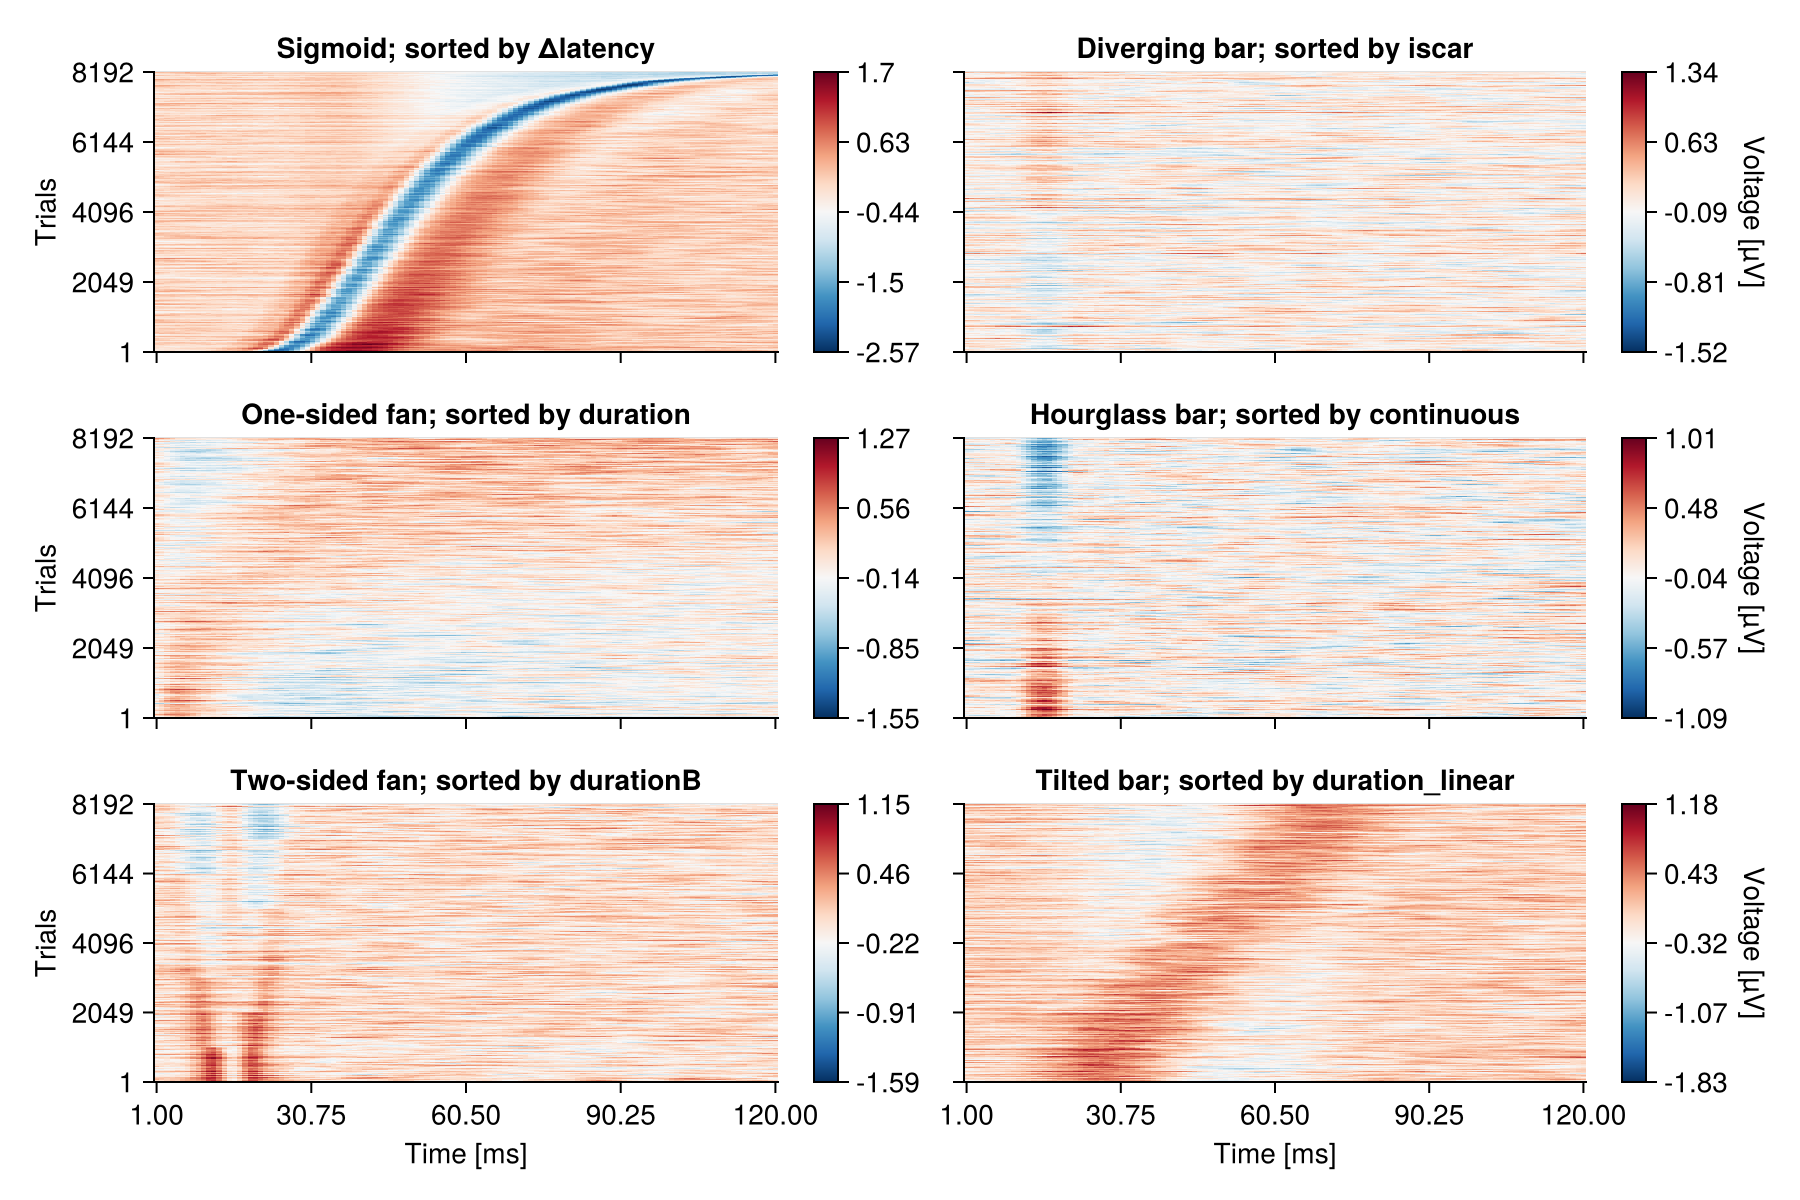

In [8]:
using CairoMakie
using UnfoldMakie
using Normalization

data_all = data
# data_all is time x trials (rows=time, columns=trials) as expected by plot_erpimage
data_norm = Normalization.normalize(Float64.(data_all), ZScore; dims = 2)
@assert size(data_norm, 2) == length(evts.Δlatency)

begin
    f = Figure(size = (900, 600))
    plot_erpimage!(
        f[1, 1],
        data_norm;
        sortvalues = evts.Δlatency,
        axis = (; title = "Sigmoid; sorted by Δlatency", xlabelvisible = false, xticklabelsvisible = false),
        colorbar = (; label = ""),
    )
    plot_erpimage!(
        f[2, 1],
        data_norm;
        sortvalues = evts.duration,
        axis = (; title = "One-sided fan; sorted by duration", xlabelvisible = false, xticklabelsvisible = false),
        colorbar = (; label = ""),
    )
    plot_erpimage!(
        f[3, 1],
        data_norm;
        sortvalues = evts.durationB,
        axis = (; title = "Two-sided fan; sorted by durationB", xlabel = "Time [ms]"),
        colorbar = (; label = ""),
    )
    plot_erpimage!(
        f[1, 2],
        data_norm;
        sortvalues = evts.condition .== "car",
        axis = (; title = "Diverging bar; sorted by iscar", xlabelvisible = false, xticklabelsvisible = false, ylabelvisible = false, yticklabelsvisible = false),
    )
    plot_erpimage!(
        f[2, 2],
        data_norm;
        sortvalues = evts.continuous,
        axis = (; title = "Hourglass bar; sorted by continuous", xlabelvisible = false, xticklabelsvisible = false, ylabelvisible = false, yticklabelsvisible = false),
    )
    plot_erpimage!(
        f[3, 2],
        data_norm;
        sortvalues = evts.duration_linear,
        axis = (; title = "Tilted bar; sorted by duration_linear", xlabel = "Time [ms]", ylabelvisible = false,  yticklabelsvisible = false),
    )
    f
end


In [9]:
include("erpgen.jl")
using .ERPGen


Progress: 1/1 reps (per class=1, total images=7)
Meta: (pattern = :sigmoid, mu = 3.173191652436385, sigma = 0.46088426513266817, maxlength = 164, condition_levels = 7, noise = "PinkNoise", noiselevel = 13)


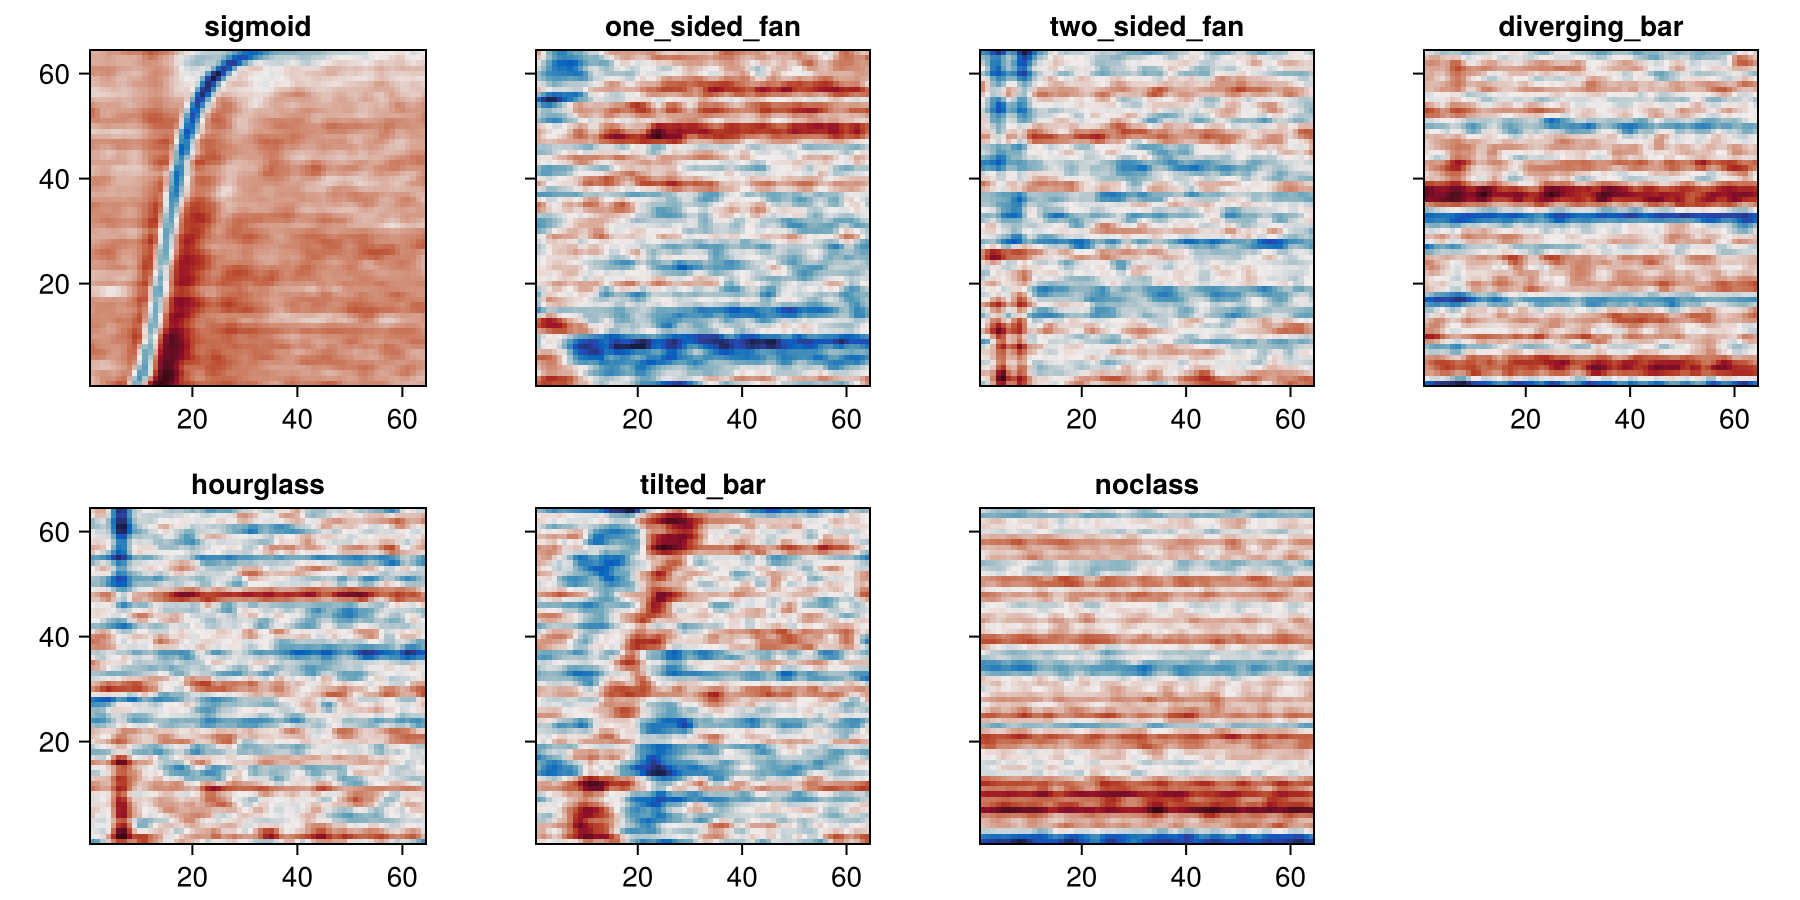

In [10]:
# Compact overview: 7 images (per class, incl. noclass) in a grid (4 + 3)

if !isdefined(Main, :ERPGen)
    include("erpgen.jl")
    using .ERPGen
end

noiselevel_mean = 5.0
noiselevel_dist = Geometric(1 / noiselevel_mean)

images, labels, metadata = generate_erp_images(
    n_per_pattern = 1,
    mu_mean = 3.2,
    mu_sd = 0.5,
    sigma_mean = 0.5,
    sigma_sd = 0.2,
    maxlength_mean = 100,
    maxlength_sd = 25,
    condition_levels_min = 3,
    condition_levels_max = 10,
    target_height = 64,
    target_width = 64,
    zscore_timepoints = true,
    gauss_sigma = 1.0,
    gauss_smooth = false,
    gauss_kernel_len = 20,
    resize_antialias = true,
    antialias_factor = 0.75,
    noise_pool = DEFAULT_NOISE_POOL,
    noiselevel_dist = noiselevel_dist,
    rng = MersenneTwister(time_ns()),
)

using CairoMakie

label_to_idx = Dict{Symbol, Int}()
for (i, lbl) in enumerate(labels)
    if !haskey(label_to_idx, lbl)
        label_to_idx[lbl] = i
    end
end

pattern_names = PATTERN_NAMES
if !(:noclass in pattern_names)
    pattern_names = vcat(pattern_names, :noclass)
end

ncols = 4
nrows = 2
fig = Figure(size = (900, 450), figure_padding = 5)
rowgap!(fig.layout, 10)
colgap!(fig.layout, 10)
first_idx = nothing
for (i, pname) in enumerate(pattern_names)
    idx = get(label_to_idx, pname, nothing)
    idx === nothing && continue

    img = images[idx]
    first_idx === nothing && (first_idx = idx)

    row = i <= 4 ? 1 : 2
    col = i <= 4 ? i : (i - 4)

    ax = Axis(fig[row, col]; title = string(pname), xlabelvisible = row == nrows, ylabelvisible = col == 1, yticklabelsvisible = col == 1, aspect = AxisAspect(1))
    heatmap!(ax, permutedims(img, (2, 1)); colormap = :balance)
end

if first_idx !== nothing
    println("Meta: ", metadata[first_idx])
end

fig


In [ ]:
# Large dataset and save as JLD2
using Random

if !isdefined(Main, :ERPGen)
    include("erpgen.jl")
    using .ERPGen
end

println("Threads verfuegbar: ", Threads.nthreads())

# Save inside the notebooks datasets folder.
dataset_dir = abspath(joinpath(pwd(), "..", "datasets"))

rng_seed = time_ns()

noiselevel_mean = 8.0
noiselevel_dist = Geometric(1 / noiselevel_mean)

n_per_pattern = 1000
mu_mean = 3.2
mu_sd = 1.0
sigma_mean = 0.5
sigma_sd = 0.2
maxlength_mean = 100
maxlength_sd = 35
maxlength_min = 40
condition_levels_min = 3
condition_levels_max = 10
target_height = 64
target_width = 64
zscore_timepoints = true
gauss_sigma = 1.0
gauss_smooth = false
gauss_kernel_len = 20
resize_antialias = true
antialias_factor = 0.75
noise_pool = DEFAULT_NOISE_POOL
threaded = true
blas_threads = 1
progress_every = 20

images_big, labels_big, metadata_big = generate_erp_images(
    n_per_pattern = n_per_pattern,
    mu_mean = mu_mean,
    mu_sd = mu_sd,
    sigma_mean = sigma_mean,
    sigma_sd = sigma_sd,
    maxlength_mean = maxlength_mean,
    maxlength_sd = maxlength_sd,
    maxlength_min = maxlength_min,
    condition_levels_min = condition_levels_min,
    condition_levels_max = condition_levels_max,
    target_height = target_height,
    target_width = target_width,
    zscore_timepoints = zscore_timepoints,
    gauss_sigma = gauss_sigma,
    gauss_smooth = gauss_smooth,
    gauss_kernel_len = gauss_kernel_len,
    resize_antialias = resize_antialias,
    antialias_factor = antialias_factor,
    noise_pool = noise_pool,
    noiselevel_dist = noiselevel_dist,
    threaded = threaded,
    parallel_mode = :processes,
    n_workers = 16,
    blas_threads = blas_threads,
    progress_every = progress_every,
    rng = MersenneTwister(rng_seed),
)

settings = (
    n_per_pattern = n_per_pattern,
    mu_mean = mu_mean,
    mu_sd = mu_sd,
    sigma_mean = sigma_mean,
    sigma_sd = sigma_sd,
    maxlength_mean = maxlength_mean,
    maxlength_sd = maxlength_sd,
    maxlength_min = maxlength_min,
    condition_levels_min = condition_levels_min,
    condition_levels_max = condition_levels_max,
    target_height = target_height,
    target_width = target_width,
    zscore_timepoints = zscore_timepoints,
    gauss_sigma = gauss_sigma,
    gauss_smooth = gauss_smooth,
    gauss_kernel_len = gauss_kernel_len,
    resize_antialias = resize_antialias,
    antialias_factor = antialias_factor,
    noise_pool = map(x -> string(typeof(x)), noise_pool),
    noiselevel_mean = noiselevel_mean,
    noiselevel_dist = string(noiselevel_dist),
    threaded = threaded,
    parallel_mode = :processes,
    n_workers = 16,
    blas_threads = blas_threads,
    progress_every = progress_every,
    rng_seed = rng_seed,
    pattern_names = PATTERN_NAMES,
)

environment = (
    julia_version = string(VERSION),
    nthreads = Threads.nthreads(),
)

# Save inside the project datasets folder.
dataset_dir = abspath(joinpath(pwd(), "..", "..", "datasets"))
dataset_path = save_erp_dataset(images_big, labels_big, metadata_big;
    dataset_dir = dataset_dir,
    prefix = "erp_dataset",
    settings = settings,
    environment = environment,
)

println("images: ", length(images_big), ", labels: ", length(labels_big), ", metadata: ", length(metadata_big))
println("Saved to: ", dataset_path)